In [3]:
import scipy.io as scio
import matplotlib.pyplot as plt

data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')

matrix_data = data['data']

print(f"\nType of 'data':", type(matrix_data))
print(f"Shape of 'data':", matrix_data.shape)


Type of 'data': <class 'numpy.ndarray'>
Shape of 'data': (16, 604700)


In [4]:
data = scio.loadmat('C:/Users/Brilliant/Desktop/data.mat')
matrix_data = data['data']
# 提取第一行（第一通道的EEG数据）
first_channel = matrix_data[0, :]
sampled_data = first_channel[:50000:10]

In [5]:
len(sampled_data)

5000

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [17:57<00:00,  5.39s/it]


均方根误差 (RMSE): 8.0583


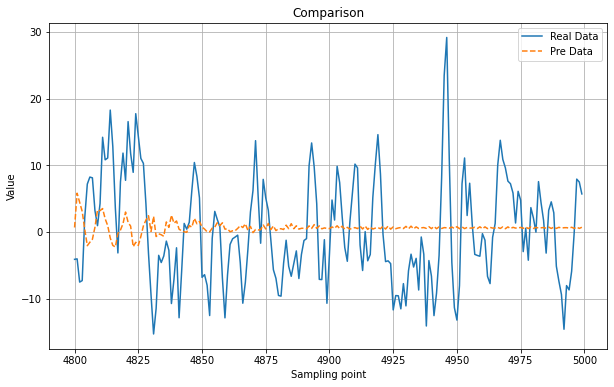

频谱相似度: 0.5935


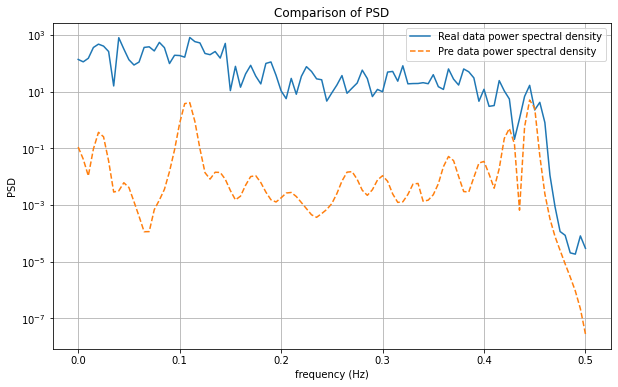

功率谱密度 (PSD) 相似度: 0.3147


In [8]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(100, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.01, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Training Progress: 100%|█████████████████████████████████████████████████████████████| 100/100 [07:44<00:00,  4.64s/it]


均方根误差 (RMSE): 8.6218


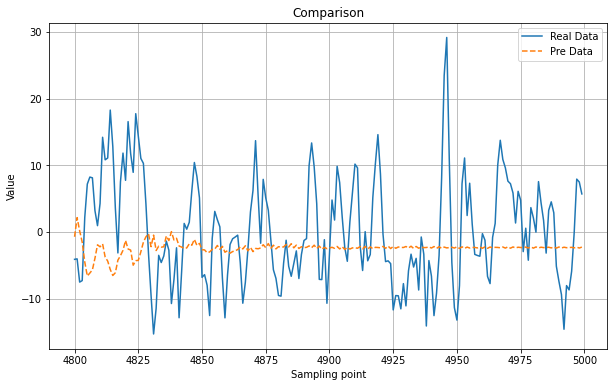

频谱相似度: 0.3266


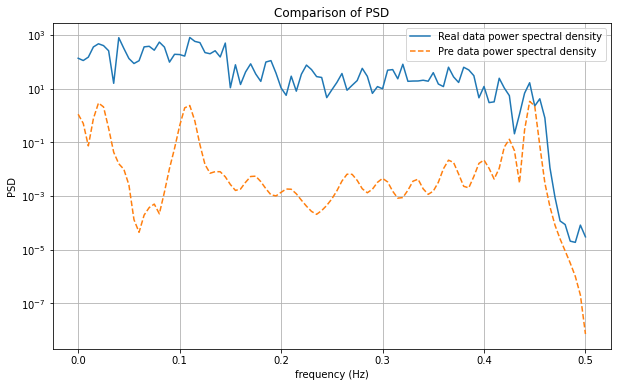

功率谱密度 (PSD) 相似度: 0.4321


In [9]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(100, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.01, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 使用 tqdm 进度条
epochs = 100
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


## 改epoch

In [ ]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(100, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.01, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 使用 tqdm 进度条
epochs = 50
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')


Training Progress:  54%|██████████████████████████████████                             | 27/50 [02:08<01:47,  4.69s/it]

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [16:02<00:00,  4.81s/it]


均方根误差 (RMSE): 9.7691


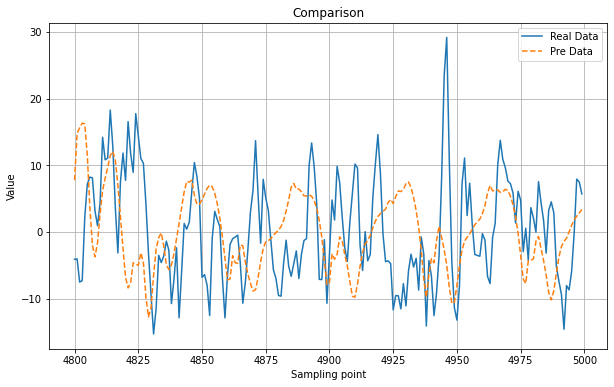

频谱相似度: 0.5880


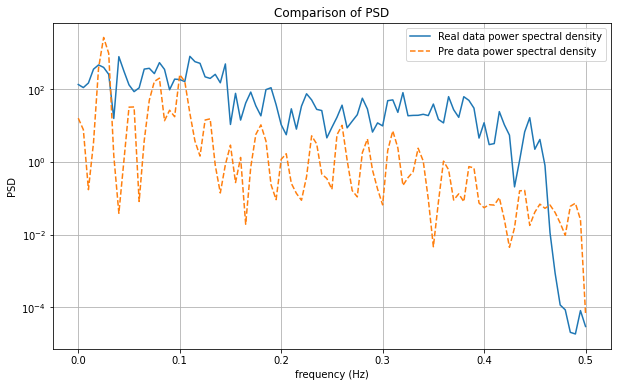

功率谱密度 (PSD) 相似度: 0.3099


In [11]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(100, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.001, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

Training Progress: 100%|█████████████████████████████████████████████████████████████| 200/200 [08:51<00:00,  2.66s/it]


均方根误差 (RMSE): 10.6437


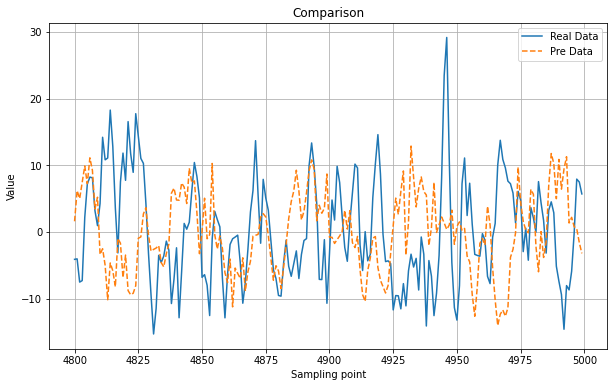

频谱相似度: 0.7650


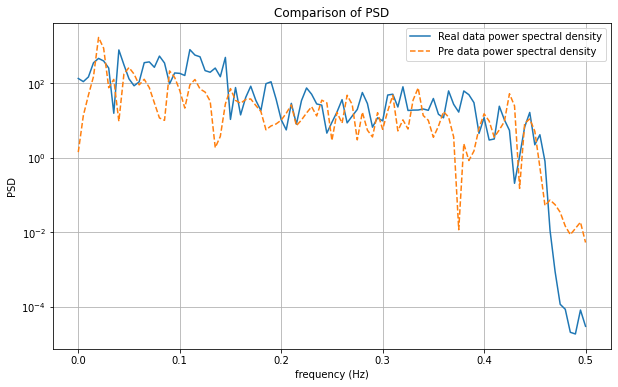

功率谱密度 (PSD) 相似度: 0.4376


In [12]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 假设已经有 sampled_data 变量包含了 5000 个点的数据
# 数据划分并标准化
scaler = MinMaxScaler(feature_range=(-1, 1))  # 使用 MinMaxScaler 进行标准化
sampled_data = sampled_data[:5000]  # 已经采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)  # 标准化训练数据
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)  # 标准化测试数据

n_steps = 30  # 调整时间步长，避免过长的时间依赖造成梯度消失
X = []
y = []

# 构建 LSTM 输入，滑动窗口构造样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i+n_steps])
    y.append(train_data[i+n_steps])

X, y = np.array(X), np.array(y)

# 构建 LSTM 模型，加入 BatchNormalization，使用梯度裁剪防止梯度爆炸
model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))  # 使用tanh激活函数避免梯度消失
model.add(BatchNormalization())  # 批量归一化
model.add(LSTM(50, activation='tanh'))  # 使用tanh激活函数
model.add(BatchNormalization())  # 批量归一化
model.add(Dense(1))  # 输出层

# 使用梯度裁剪，防止梯度爆炸
optimizer = Adam(learning_rate=0.01, clipvalue=1.0, amsgrad=True)  # clipvalue防止梯度爆炸
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器，随着训练过程逐步降低学习率
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # 创建 LambdaCallback，来在每个 epoch 结束时更新进度条
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 调整为 LSTM 输入格式
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)

    # 检查预测值是否异常，避免 NaN 或 inf
    if np.isnan(predicted) or np.isinf(predicted):
        print(f'Warning: Invalid predicted value at step {_}, setting to 0.')
        predicted[0][0] = 0  # 处理异常值

    predicted_points.append(predicted[0][0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0][0]).reshape(1, 1, 1)
    X_input = np.append(X_input[:, 1:, :], predicted_reshaped, axis=1)

predicted_points = np.array(predicted_points)  # 将预测结果转换为 NumPy 数组

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Pre Data', linestyle='--')
plt.title('Comparison')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
# 对真实值和预测值做 FFT 变换
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD) 用于频域特征匹配
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)  # Welch 方法计算真实数据的功率谱密度
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)  # 计算预测数据的功率谱密度

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real data power spectral density')
plt.semilogy(f_pred, psd_pred, label='Pre data power spectral density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')

In [ ]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D, 
                                     BatchNormalization, Activation, AveragePooling2D, 
                                     SpatialDropout2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import welch

# 固定随机种子
random.seed(23)
np.random.seed(24)
tf.random.set_seed(25)

# 数据标准化
scaler = MinMaxScaler(feature_range=(-1, 1))
sampled_data = sampled_data[:5000]  # 已采样好的5000个点
train_data = scaler.fit_transform(sampled_data[:4800].reshape(-1, 1)).reshape(-1)
test_data = scaler.transform(sampled_data[4800:].reshape(-1, 1)).reshape(-1)

n_steps = 30
X, y = [], []

# 构建滑动窗口样本
for i in range(len(train_data) - n_steps):
    X.append(train_data[i:i + n_steps])
    y.append(train_data[i + n_steps])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], 1, n_steps, 1))  # 调整为 EEGNet 输入格式

# 构建 EEGNet 模型
def EEGNet(nb_classes=1, Chans=1, Samples=n_steps, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16):
    input1 = Input(shape=(Chans, Samples, 1))
    x = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, 
                        depthwise_constraint=tf.keras.constraints.max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = SpatialDropout2D(dropoutRate)(x)
    
    x = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = SpatialDropout2D(dropoutRate)(x)
    
    x = Flatten()(x)
    x = Dense(nb_classes)(x)
    return Model(inputs=input1, outputs=x)

# 创建并编译模型
model = EEGNet(nb_classes=1)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# 学习率调度器
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# 使用 tqdm 进度条
epochs = 200
with tqdm(total=epochs, desc="Training Progress") as pbar:

    def on_epoch_end(epoch, logs):
        pbar.update(1)

    # LambdaCallback 进度条更新
    progress_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    # 模型训练
    model.fit(X, y, epochs=epochs, batch_size=32, shuffle=False, verbose=0, callbacks=[progress_callback, lr_scheduler])

# 用模型预测未来 200 个点
X_input = train_data[-n_steps:].reshape((1, 1, n_steps, 1))  # 取最后 30 个点作为输入
predicted_points = []

for _ in range(200):
    predicted = model.predict(X_input, verbose=0)
    predicted_points.append(predicted[0, 0])

    # 滑动窗口更新
    predicted_reshaped = np.array(predicted[0, 0]).reshape(1, 1, 1, 1)
    X_input = np.append(X_input[:, :, 1:, :], predicted_reshaped, axis=2)

predicted_points = np.array(predicted_points)

# 反归一化预测结果和测试数据
predicted_points_rescaled = scaler.inverse_transform(predicted_points.reshape(-1, 1)).reshape(-1)
test_data_rescaled = scaler.inverse_transform(test_data.reshape(-1, 1)).reshape(-1)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data_rescaled, predicted_points_rescaled))
print(f'均方根误差 (RMSE): {rmse:.4f}')

# 绘制预测结果与真实数据的对比图
plt.figure(figsize=(10, 6))
plt.plot(range(4800, 5000), test_data_rescaled, label='Real Data')
plt.plot(range(4800, 5000), predicted_points_rescaled, label='Predicted Data', linestyle='--')
plt.title('EEGNet Model Prediction')
plt.xlabel('Sampling point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 计算频谱相似度
fft_real = np.fft.fft(test_data_rescaled)
fft_pred = np.fft.fft(predicted_points_rescaled)

# 计算余弦相似度
fft_real_abs = np.abs(fft_real).reshape(1, -1)
fft_pred_abs = np.abs(fft_pred).reshape(1, -1)
spectral_similarity = cosine_similarity(fft_real_abs, fft_pred_abs)[0][0]
print(f'频谱相似度: {spectral_similarity:.4f}')

# 计算功率谱密度 (PSD)
f_real, psd_real = welch(test_data_rescaled, fs=1.0, nperseg=200)
f_pred, psd_pred = welch(predicted_points_rescaled, fs=1.0, nperseg=200)

# 绘制功率谱密度对比图
plt.figure(figsize=(10, 6))
plt.semilogy(f_real, psd_real, label='Real Data Power Spectral Density')
plt.semilogy(f_pred, psd_pred, label='Predicted Data Power Spectral Density', linestyle='--')
plt.title('Comparison of PSD')
plt.xlabel('frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()

# 计算频域特征匹配度 (余弦相似度)
psd_real = psd_real.reshape(1, -1)
psd_pred = psd_pred.reshape(1, -1)
psd_similarity = cosine_similarity(psd_real, psd_pred)[0][0]
print(f'功率谱密度 (PSD) 相似度: {psd_similarity:.4f}')
